In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
dataset_path = "C:/Users/sugo3/Downloads/DC"
print(os.listdir(dataset_path))

['.ipynb_checkpoints', 'BLDC_fan_motor_LSTM_AE_model.ipynb', 'DC voltage from fault BLDC motor.csv', 'DC voltage from normal BLDC motor .csv', 'weights']


In [3]:
Normal = []
Fault = []
for files in os.listdir(dataset_path):
    if 'DC voltage from fault BLDC motor.csv' in files:
        Fault.append(pd.read_csv(os.path.join(dataset_path, files)))
    elif  'DC voltage from normal BLDC motor.csv' in files:
        Normal.append(pd.read_csv(os.path.join(dataset_path, files)))


In [4]:
Normal_data = pd.concat(Normal)
Fault_data = pd.concat(Fault)

# Data Argumentation

# 1. LPF, HPF

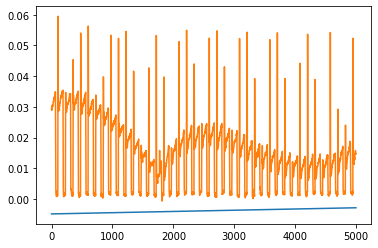

In [5]:
plt.plot(Normal_data[0:5000])

In [6]:
from scipy import signal
from scipy.io import wavfile

# LPF

In [7]:
sr = len(Normal_data)
normal_data_ampl=Normal_data['Ampl']
LPF_noraml=signal.firwin(101, cutoff=400, fs=sr, pass_zero='lowpass')
normal_data_ampl_lpf=signal.lfilter(LPF_noraml, [1.0], normal_data_ampl)

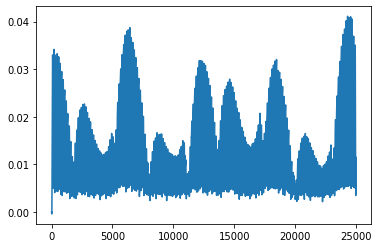

In [8]:
plt.plot(normal_data_ampl_lpf)

# HPF

In [9]:
sr = len(Normal_data)
normal_data_ampl=Normal_data['Ampl']
HPF_noraml=signal.firwin(101, cutoff=100, fs=sr, pass_zero='highpass')
normal_data_ampl_hpf=signal.lfilter(HPF_noraml, [1.0], normal_data_ampl)

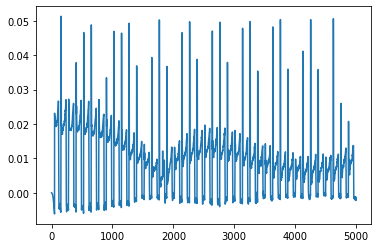

In [10]:
plt.plot(normal_data_ampl_hpf[0:5000])

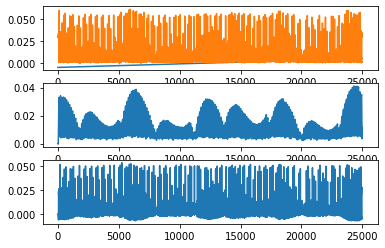

In [11]:
plt.subplot(3,1,1)
plt.plot(Normal_data)
plt.subplot(3,1,2)
plt.plot(normal_data_ampl_lpf)
plt.subplot(3,1,3)
plt.plot(normal_data_ampl_hpf)

--> LPF로 노이즈 제거하기!

# 2.Modeling
LSTM-AE 이외에도 seq2seq같은 다양한 모델 해봐도 좋을듯

In [12]:
from tensorflow.keras import Model, models, layers, optimizers, utils, Input
from tensorflow.keras.layers import Dense
import tensorflow as tf

In [13]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = layers.LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.00))(inputs)
    L2 = layers.LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = layers.RepeatVector(1)(L2)
    L4 = layers.LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = layers.LSTM(16, activation='relu', return_sequences=True)(L4)
    output = layers.TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

# 2.1 Preproceesing for LSTM network
1. first normalize it to a range between 0 and 1
2. replace data into a format suitable for input an LSTM network (LSTM cells expect a 3  dimensional tensor of the form [ data samples , time steps , features ])
> each sample input into the LSTM network represents one step in time and contains 1 features - the sensor reading for one Motor at that time step.
> 

1. 정상 데이터에서 시간 t가 5100에서 8100 사이의 데이터를 이용해 
2. 정상 데이터에서 시간 t가 8100에서 11000 사이의 데이터를 예측
3. 즉, 각 데이터당 입력시간 t를 기준으로 3000이후의 예측을 수행

In [23]:
X_train = normal_data_ampl_lpf[5100:8100]
y_train = normal_data_ampl_lpf[8100:11100]

LSTM에 입력하기 위해 데이터 Reshape

In [24]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [25]:
X_train = X_train.reshape(X_train.shape[0], 1, 1).astype(np.float64)
print("Training data shapes : ", X_train.shape)

Training data shapes :  (3000, 1, 1)


In [26]:
y_train = y_train.reshape(y_train.shape[0], 1, 1).astype(np.float64)
print("label data shapes : ", X_train.shape)

label data shapes :  (3000, 1, 1)


# 2.2 Input the X_train in the Model 

In [27]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)             

In [28]:
# fit the model to the data
EPOCHS=100
BATCH_SIZE=10
#X_train = np.expand_dims(X_train,axis=2)
history = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_split=0.05).history

Epoch 1/100
285/285 [==============================] - 2s 6ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 2/100
285/285 [==============================] - 1s 4ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 3/100
285/285 [==============================] - 1s 4ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 4/100
285/285 [==============================] - 1s 4ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 5/100
285/285 [==============================] - 1s 4ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 6/100
285/285 [==============================] - 1s 4ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 7/100
285/285 [==============================] - 1s 4ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/100
285/285 [==============================] - 1s 4ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/100
285/285 [==============================] - 1s 4ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 10/100
285/285 [==============================] - 1s 4ms/step - loss: 0.0028 - val_lo

285/285 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 82/100
285/285 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 83/100
285/285 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 84/100
285/285 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 85/100
285/285 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 86/100
285/285 [==============================] - 1s 4ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 87/100
285/285 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 88/100
285/285 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 89/100
285/285 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 90/100
285/285 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 

# 2.3 정상 데이터 학습 예측 결과
(주기 계산하는 시퀸스가 필요할듯)

In [29]:
yhat = model.predict(X_train)

In [33]:
yhat = yhat.reshape(len(yhat))

Text(0.5, 0, 'Time(secs)')

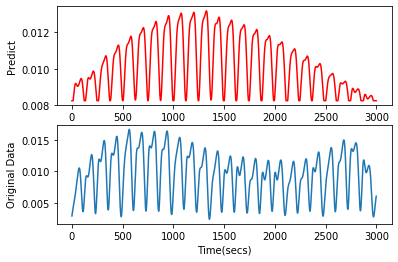

In [66]:
%matplotlib inline
plt.subplot(2,1,1)
plt.plot(yhat,'r') # 시간 t3000 이후의 예측 데이터
plt.ylabel('Predict')
plt.xlabel('Time(secs)')
plt.subplot(2,1,2)
plt.plot(normal_data_ampl_lpf[8100:11100]) # 원래 데이터
plt.ylabel('Original Data')
plt.xlabel('Time(secs)')

# 3. Test on Fault

In [74]:
fault_data_ampl=Fault_data['Ampl']

In [75]:
fault_data_ampl=fault_data_ampl[1000:5000]

In [76]:
fault_data_ampl_lpf=signal.lfilter(LPF_noraml, [1.0], fault_data_ampl)

In [77]:
fault_train = fault_data_ampl_lpf.reshape(fault_data_ampl_lpf.shape[0], 1, 1).astype(np.float64)

# 3.1 test 예측값

In [78]:
on_error = model.predict(fault_train)
on_error = on_error.reshape(len(on_error))

# 3.2 실제 값

In [79]:
fault_data_ampl2=Fault_data['Ampl']
fault_data_ampl2=fault_data_ampl2[5000:9000]
fault_data_ampl_lpf2=signal.lfilter(LPF_noraml, [1.0], fault_data_ampl2)

Text(0.5, 0, 'Time(secs)')

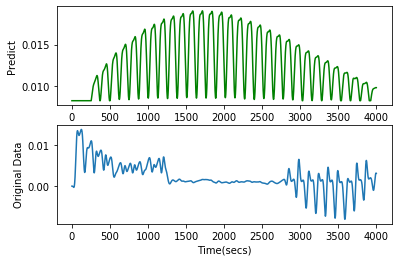

In [80]:
plt.subplot(2,1,1)
plt.plot(on_error,'g') # 시간 t3000 이후의 예측 데이터
plt.ylabel('Predict')
plt.xlabel('Time(secs)')
plt.subplot(2,1,2)
plt.plot(fault_data_ampl_lpf2) # 원래 데이터
plt.ylabel('Original Data')
plt.xlabel('Time(secs)')

예측값과 실제 값의 차이가 상당히 많이 남으로 이상으로써 탐지

하지만 수식에 근거하는 Threshold를 정의해야할 필요가 있음

# 4. 가중치 저장

In [73]:
weights_path = 'C:/Users/sugo3/Downloads/DC/'
model.save(weights_path+'lstm_ae.h5')